<a href="https://colab.research.google.com/github/machine-perception-robotics-group/ImageProcessingGoogleColabNotebooks/blob/master/05_binary_image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 05. 二値化，二値画像処理

講義で説明する画像処理の方法について，google colaboratoryを利用して演習する．
google colaboratoryは，クラウドで実行する Jupyter ノートブック環境である.
google coraboratoryについては，[ここ](https://www.tdi.co.jp/miso/google-colaboratory-gpu)や[ここ](https://www.codexa.net/how-to-use-google-colaboratory/)を参考にすること．

下記のプログラムを実行すると，画像の二値化や二値化した画像の処理を行う．

## 準備
プログラムの動作に必要なデータをダウンロードし，zipファイルを解凍する．

In [0]:
!wget -q http://www.mprg.cs.chubu.ac.jp/Tutorial/ML_Lecture/tutorial_ip_2020/image1.zip
!unzip -q image1.zip
!ls
!ls ./image1/

image1	image1.zip  sample_data
168065B.JPG	 Blackboard3.jpg  woman-color.jpg  woman-n.jpg
Blackboard1.jpg  coin.png	  woman-g2.jpg	   woman-s.jpg
Blackboard2.jpg  ipod.png	  woman-g.jpg	   woman-t.jpg


## 画像の読み込みと表示
必要なパッケージをインポートし，画像を表示する．

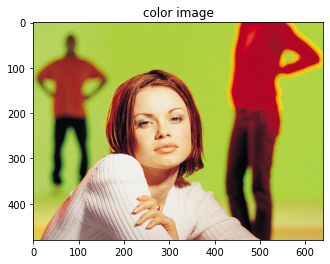

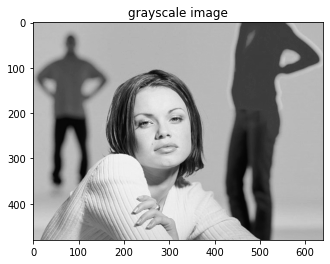

In [0]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

#カラー画像の読み込み
img_src = cv2.imread('./image1/woman-color.jpg')
img_rgb = cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB)
#グレースケール画像の読み込み
img_gray = cv2.cvtColor(img_src, cv2.COLOR_BGR2GRAY)

#画像を表示
plt.imshow(img_rgb)
plt.title("color image")
plt.show()

plt.imshow(img_gray, cmap="gray")
plt.title("grayscale image")
plt.show()

## グレースケール変換

ここでは，複数の方法でカラー画像をグレースケール画像へと変換する．


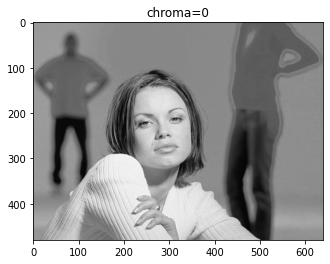

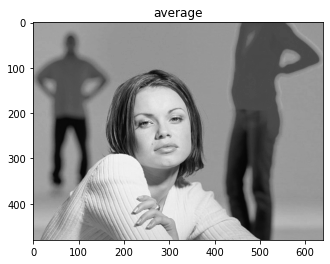

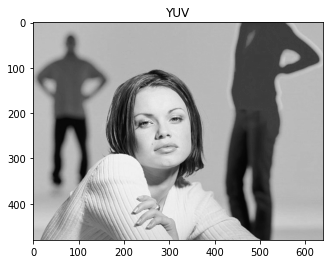

In [0]:
img = img_rgb.copy()

# 高さ・幅・チャンネル数の取得
height, width, channel = img.shape

# 要素が全て0の3次元配列を作成
image_array1 = np.zeros((height, width), dtype=np.uint8)
image_array2 = np.zeros((height, width), dtype=np.uint8)
image_array3 = np.zeros((height, width), dtype=np.uint8)

# RGBをソート
img_sort = np.sort(img, axis=2)

# 配列の各要素に値（画素値）を代入
for h in range(0, height):
    for w in range(0, width):
      # 彩度0
      image_array1[h, w] = (img_sort[h, w, 0] * 1 + img_sort[h, w, 2] * 1) / 2.0
      # RGBの平均値
      image_array2[h, w] = (img[h, w, 0] * 1 + img[h, w, 1] * 1 + img[h, w, 2] * 1) / 3
      # YUV(0.299*R + 0.587*G + 0.114*B)色ごとの明るさの感じ方の違いを反映
      image_array3[h, w] = (img[h, w, 0] * 0.299) + (img[h, w, 1] * 0.587) + (img[h, w, 2] * 0.114) 

# 画像の表示
plt.imshow(image_array1, cmap="gray")
plt.title("saturation=0")
plt.show()

plt.imshow(image_array2, cmap="gray")
plt.title("average")
plt.show()

plt.imshow(image_array3, cmap="gray")
plt.title("YUV")
plt.show()

## 二値化

次の方法がある．
* 手動で閾値を選択する方法
* pタイル法
* モード法
* 判別分析法

以下では，それぞれの方法を用いて画像の二値化を行う．

※ 手動で閾値を設定する場合の画像を二値化は，01「画像の濃淡ヒストグラム」にて行なっている．詳細についてはそちらを参考にすること．

まずは，


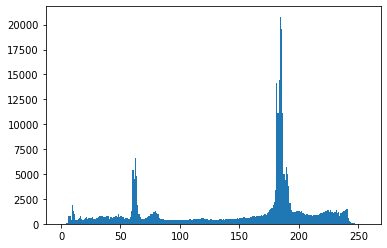

In [0]:
# 上で読み込んだグレースケール画像をコピー
img = img_gray.copy()

# hist関数を使用して濃淡ヒストグラムを作成
plt.hist(img.ravel(), 256, [0, 256])

# 作成したヒストグラムを表示
plt.show()

### pタイル法


pタイル法では，画素値の低いところから頻度値を計算し，予測された画素数を超えた時の画素値をしきい値として決定する．



In [0]:
#上で読み込んだ低コントラストグレースケール画像をコピー
img = img_gray.copy()

# 高さ・幅の取得
height, width = img.shape

# 画像の画素数を計算
imgsize = height * width

# ヒストグラムを計算するための，配列を用意
histogram = np.arange(256)

# for文で1つずつ画素値にアクセスする
for h in range(height):
  for w in range(width):
    # 1画素ずつ画素値を見ながら該当する要素（bin）に投票
    histogram[img[h][w]] += 1

# 領域の割合（比率）を決定
ratio = 0.4

th = height * width * ratio
th_sum = 0
for ti in range(256):
  th_sum += histogram[ti]
  if th_sum > th:
    threshold = ti
    break

print("THRESHOLD =", threshold)

THRESHOLD = 160


上のpタイル法で求めた閾値を用いて二値画像を作成する．

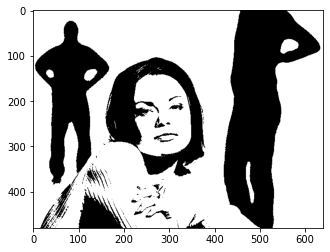

In [0]:
img_bin_ptile = img.copy()

for i in range(height):
  for j in range(width):
    # 閾値未満なら
    if img_bin_ptile[i][j] < threshold:
      img_bin_ptile[i][j] = 0
    # それ以外
    else:
      img_bin_ptile[i][j] = 255



plt.imshow(img_bin_ptile, cmap="gray")
plt.show()

### モード法



peak: [ 60 181]
minima (threshold): 93


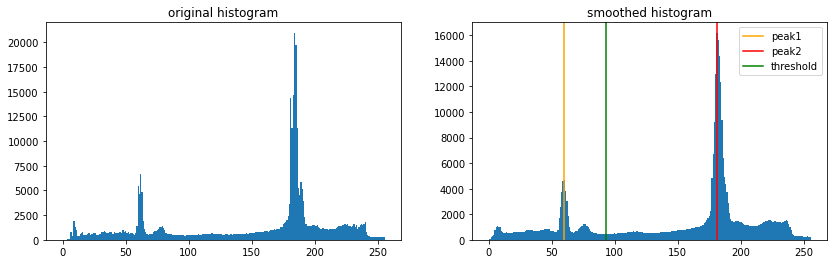

In [0]:
#上で読み込んだ低コントラストグレースケール画像をコピー
img = img_gray.copy()

# 高さ・幅の取得
height, width = img.shape

# 画像の画素数を計算
imgsize = height * width

# ヒストグラムの計算
histogram = np.arange(256)
for h in range(height):
  for w in range(width):
    # 1画素ずつ画素値を見ながら該当する要素（bin）に投票
    histogram[img[h][w]] += 1

# ヒストグラムの平滑化
hist_sm = histogram.copy()
for i in range(256 - 4):
  hist_sm[i] = np.mean(histogram[i:i+5])

# 平滑化したヒストグラムを用いて山（極大値）を探索
maxima_list = np.zeros(256)
for i in range(256 - 3):
  if hist_sm[i] < hist_sm[i+1] and hist_sm[i+2] < hist_sm[i+1]:
    maxima_list[i+1] = hist_sm[i+1]

# 値の高い極大値２つを選択する
maxima_indices = np.argsort(maxima_list)
peak = np.sort(maxima_indices[-2:])
print("peak:", peak)

# 極大値の間でもっとも頻度が低い画素値（閾値）を求める
minima = [-1, 20000]
for i in range(peak[0], peak[1]):
  if hist_sm[i] < minima[1]:
    minima = [i, hist_sm[i]]

threshold = minima[0]
print("minima (threshold):", threshold)

# 平滑化したヒストグラムの表示
plt.figure(figsize=(14, 4))
plt.subplot(121)
plt.bar(range(256), histogram, width=1.0)
plt.title("original histogram")
plt.subplot(122)
plt.bar(range(256), hist_sm, width=1.0)
plt.title("smoothed histogram")
plt.axvline(peak[0], color="orange", label='peak1')
plt.axvline(peak[1], color="red", label='peak2')
plt.axvline(threshold, color="green", label='threshold')
plt.legend()
plt.show()

上のモード法で求めた閾値を用いて，画像を二値化する．

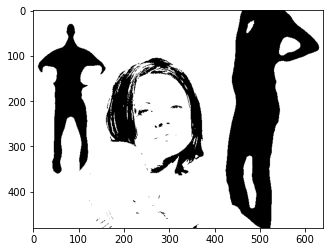

In [0]:
img_bin_mode = img.copy()

for i in range(height):
  for j in range(width):
    # 閾値未満なら
    if img_bin_mode[i][j] < threshold:
      img_bin_mode[i][j] = 0
    # それ以外
    else:
      img_bin_mode[i][j] = 255

plt.imshow(img_bin_mode, cmap="gray")
plt.show()

### 判別分析法


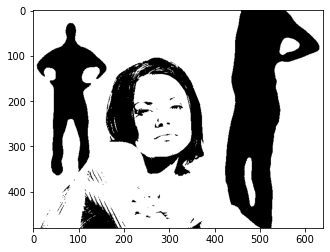

In [0]:
#上で読み込んだ低コントラストグレースケール画像をコピーし高さ・幅を取得
img = img_gray.copy()
height, width = img.shape

# 画像の画素数を計算
imgsize = height * width

# ヒストグラムの計算
histgram = np.arange(256)
for h in range(height):
  for w in range(width):
    histgram[img[h][w]] += 1

# 閾値とクラス間分散を保存するためのリストを用意
s_max = [0, -10]

for th in range(256):
  # クラス1とクラス2の画素数を計算
  n1 = sum(histgram[:th])
  n2 = sum(histgram[th:])

  # クラス1とクラス2の画素値の平均を計算
  if n1 == 0:
    mu1 = 0
  else:
    mu1 = sum([i * histgram[i] for i in range(0,th)]) / n1   
  if n2 == 0:
    mu2 = 0
  else:
    mu2 = sum([i * histgram[i] for i in range(th, 256)]) / n2

  # クラス1とクラス2の間の分散（クラス間分散）の分子を計算
  s = n1 * n2 * (mu1 - mu2) ** 2

  # クラス間分散の分子が大きい時，クラス間分散の分子と閾値を記録
  if s > s_max[1]:
    s_max = [th, s]
    
# クラス間分散が最大のときの閾値を取得
threshold = s_max[0]

# 算出した閾値で二値化処理
img_bin_da = img.copy()
img_bin_da[img_bin_da < threshold] = 0
img_bin_da[img_bin_da >= threshold] = 255

# 表示
plt.imshow(img_bin_da, cmap="gray")
plt.show()

## 二値画像処理


まず，二値画像処理に使用する二値画像を用意する．
今回は，OpenCVの`threshold`関数を用いて判別分析法により二値画像を用意する．

threshold: 124.0


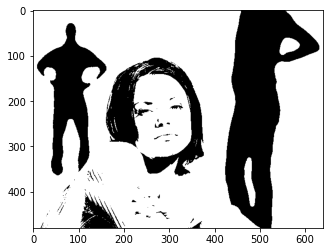

In [0]:
img = img_gray.copy()
th, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
print("threshold:", th)

plt.imshow(img_bin, cmap="gray")
plt.show()

### 縮小・膨張処理


#### 収縮 (erosion)

背景または穴に接する対象画素のひとまわりを剥ぎ取る処理

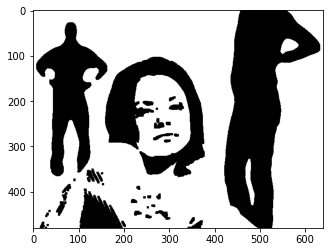

In [0]:
img = img_bin.copy()
kernel = np.ones((5, 5), np.uint8)
erosion = cv2.erode(img, kernel, iterations=1)

plt.imshow(erosion, cmap="gray")

#### 膨張 (dilation)

背景または穴に接する対象画素のひとまわりを加える処理

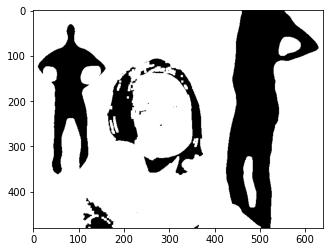

In [0]:
img = img_bin.copy()
kernel = np.ones((5, 5), np.uint8)
dilation = cv2.dilate(img, kernel, iterations=1)

plt.imshow(dilation, cmap="gray")

#### オープニング (opening)

同じ回数だけ**収縮**して**膨張**する処理 

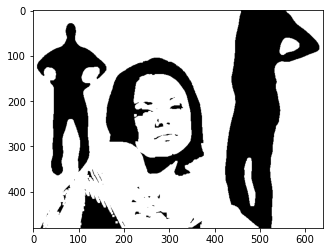

In [0]:
img = img_bin.copy()
opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

plt.imshow(opening, cmap="gray")

#### クロージング (closing)

同じ回数だけ**膨張**して**収縮**する処理

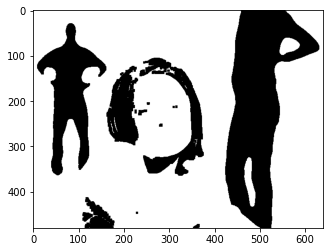

In [0]:
img = img_bin.copy()
closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

plt.imshow(closing, cmap="gray")

### ラベリング統計量？


## 課題

* グレースケール変換時のRGBの比率を変更して，変換結果を確認すること
* pタイル法の比率を変更して，適切な比率を確認すること
* 縮小・膨張処理のkernelを変更して，変化を確認すること